In [ ]:
pip install langchain==0.2.11 langchain-community==0.2.10 scikit-learn==1.5.0 langchain-openai==0.1.22 langgraph==0.2.59 azure-search-documents azure-identity

In [2]:
from langgraph.graph import StateGraph
from typing import TypedDict, List
import os
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


In [69]:
class AgentState(TypedDict):
    question: str
    agent_rag: str
    answer: str
    

In [80]:
agents = ["agent_rag"]

## RAG agent

Retrieves relevant information from a predefined knowledge base and uses this context to generate accurate and contextually relevant responses.

In [76]:
class AgentRag:
    
    def __init__(self, index): 
        # Embeddings model instantiation
        self.embeddings = AzureOpenAIEmbeddings(model="ada-002", openai_api_version="2024-06-01")
        
        # Vector store instantiation
        self.vstore = AzureSearch(
            azure_search_endpoint=os.getenv("AZURE_SEARCH_URI"),
            azure_search_key=os.getenv("AZURE_SEARCH_KEY"),
            index_name=index,
            embedding_function=self.embeddings.embed_query
        )

        # Instantiate a pre-trained Large Language Model from Azure OpenAI
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            "You are an AI assistant for question-answering tasks."
            "You are able to answer questions related to Fabian's final project for his master degree in AI."
            "If someone asks, 'What can I ask you about?' or other similar questions, respond with the above topics."
            "If you're unsure, use the following pieces of retrieved context to answer the question." 
            "If you don't know the answer, say that you don't know."
            "If a question does not relate to Fabian's project, respond with: 'This question falls outside of my knowledge base'." 
            "Use three sentences maximum and keep the answer concise."
            "\n\n"
            "Context: {context}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            {"context": self.retrieve, "question": RunnablePassthrough()}
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def retrieve(self, query):      
        docs = self.vstore.similarity_search(query, k=3)
        # Put together the results of the similarity search into one chunk of text
        return "\n\n".join(doc.page_content for doc in docs)

    def generate(self, state: AgentState):
        answer = self.rag_chain.invoke(state["question"])
        print(f"Agent says: {answer}")
        return { "agent_rag": answer }


In [77]:
agent_rag = AgentRag("rag-v2")

In [6]:
agent_rag.generate({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

{'agent_rag': 'El objetivo del proyecto de Fabián es desarrollar un chatbot especializado que pueda ser entrenado con documentos propietarios de una empresa. Este chatbot debe ser capaz de interpretar correctamente las consultas de los usuarios y proporcionar respuestas precisas y relevantes basadas en el contenido de los documentos.'}

## Supervisor

Picks the next agent to process and decides when the work is completed. Then generates a final answer based on the output of the other agents.

In [71]:
class Supervisor:
    
    def __init__(self, agent_list): 

        # List with all the agents to supervise
        self.agents = agent_list

        # Instantiate a pre-trained Large Language Model from Azure OpenAI
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            f"You are a supervisor tasked with managing a conversation between the following workers: {self.agents}."
            "Given the following user question, all the workers will provide a response."
            "Your task is to analyze each of the responses and provide the best possible response to the user."
            "Do not make up for new information that is not explicitly in the workers response."
            "\n\n"
            "Workers response: {agents_output}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            {"question": RunnableLambda(lambda inputs: inputs["input"]), "agents_output": RunnableLambda(lambda inputs: inputs["agents_output"]), "history": RunnableLambda(lambda inputs: inputs["history"])}
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def pick_next_agent(self, state: AgentState):
        for agent in self.agents:
            if agent not in state:
                print(f"Next agent: {agent}")
                return { "next": agent }
        return { "next": "FINISH" }

    def summarize(self, state: AgentState):
        print("Summarizing...")
        agents_output = {key: state[key] for key in self.agents if key in state}
        answer = self.rag_chain.invoke({"input": state["question"], "agents_output": agents_output, "history": []})
        return { "answer": answer }


In [72]:
supervisor = Supervisor(agents)

In [39]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

'agent_rag'

In [40]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

'FINISH'

In [64]:
supervisor.summarize({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

Logging Inputs: {'question': 'hablame acerca de los objetivos del proyecto de Fabian', 'agents_output': {'agent_rag': 'El objetivo del proyecto de Fabián es desarrollar un chatbot'}, 'history': []}


{'answer': 'El objetivo del proyecto de Fabián es desarrollar un chatbot.'}

## Graph

In [78]:
builder = StateGraph(AgentState)

builder.add_node("supervisor_node", supervisor.pick_next_agent)
builder.add_node("summarizer_node", supervisor.summarize)
builder.add_node("rag_node", agent_rag.generate)

builder.add_conditional_edges(
    "supervisor_node",
    RunnableLambda(lambda inputs: inputs["next"]),  
    {"agent_rag": "rag_node", "FINISH": "summarizer_node"}
)
builder.add_edge("rag_node", "supervisor_node")

builder.set_entry_point("supervisor_node")

graph = builder.compile()

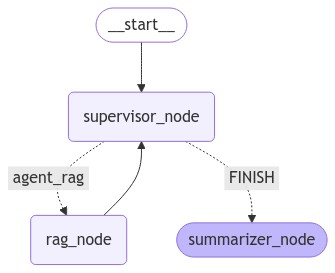

In [74]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
graph.invoke({"question": "quien es Fabian?"})

Next agent: agent_rag
Agent says: Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.
Summarizing...


{'question': 'quien es Fabian?',
 'agent_rag': 'Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.',
 'answer': 'Fabian Alejandro Massotto es un ingeniero que está realizando su Trabajo Final para la Carrera de Especialización en Inteligencia Artificial.'}